# Oklahoma County Property Analysis

In [1]:
# Install required libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from scipy.stats import linregress

## 1. Exploratory Data Analysis

### Import CSV file

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('output.csv')

# Remove specific addresses
remove_adresses = ['900 HANGAR DR']
df = df[~df['address'].isin(remove_adresses)]

# Convert string representations of Python dictionaries back into the correct data type
df['market_values'] = df['market_values'].apply(ast.literal_eval)
df['sales_prices'] = df['sales_prices'].apply(ast.literal_eval)


### Clean Data and Add Columns

In [3]:
# Extract the most recent sales price and market value
get_most_recent = lambda x: next(iter(x.values())) if x else None
df['most_recent_sales_year'] = df['sales_prices'].apply(lambda x: next(iter(x.keys())) if x else None)
df['most_recent_sales_price'] = df['sales_prices'].apply(get_most_recent)
df['most_recent_market_value'] = df['market_values'].apply(get_most_recent)

# Create total square footage feature by adding unfin_attic_sqft to the square_feet column
df['total_sqft'] = df['square_feet'] + df['unfin_attic_sqft'] + df['garage_apt_sqft']

# Calculate price/square foot
# df['price/square_foot'] = df['most_recent_sales_price'] / df['square_feet']
df['sales_price/square_foot'] = df['most_recent_sales_price'] / df['total_sqft']

# Calculate value difference between the most recent Market Value and Sales Price
df['value_diff'] = df['most_recent_market_value'] - df['most_recent_sales_price']

# Create binary value based on if the house has a garage
df['has_garage'] = df['garage_sqft'].apply(lambda x: 1 if x > 0 else 0)

# Create binary value based on if the house has a garage apartment
df['has_apt'] = df['garage_apt_sqft'].apply(lambda x: 1 if x > 0 else 0)

# Display the DataFrame
df


,address,square_feet,market_values,sales_prices,year_built,bedrooms,bathrooms,garage_sqft,garage_apt_sqft,porch_sqft,unfin_attic_sqft,most_recent_sales_year,most_recent_sales_price,most_recent_market_value,total_sqft,sales_price/square_foot,value_diff,has_garage,has_apt
0,1000 PEDALERS LN,1024.0,"{2024: 358500, 2023: 331500, 2022: 284500, 202...",{2019: 232500},2018.0,3.0,1.5,0.0,0.0,71.0,0.0,2019.0,232500.0,358500.0,1024.0,227.050781,126000.0,0,0
1,1001 PEDALERS LN,1167.0,"{2024: 395500, 2023: 369000, 2022: 317000, 202...",{2019: 246000},2018.0,3.0,1.5,0.0,0.0,69.0,0.0,2019.0,246000.0,395500.0,1167.0,210.796915,149500.0,0,0
2,1004 PEDALERS LN,766.0,"{2024: 315500, 2023: 281500, 2022: 242000, 202...","{2020: 215000, 2019: 197500}",2018.0,2.0,1.5,0.0,0.0,56.0,0.0,2020.0,215000.0,315500.0,766.0,280.678851,100500.0,0,0
3,1005 PEDALERS LN,756.0,"{2024: 311000, 2023: 277500, 2022: 237500, 202...",{2019: 191000},2018.0,1.0,1.0,0.0,0.0,102.0,0.0,2019.0,191000.0,311000.0,756.0,252.645503,120000.0,0,0
4,1008 PEDALERS LN,1164.0,"{2024: 381000, 2023: 353500, 2022: 303000, 202...",{2019: 248500},2018.0,3.0,1.5,0.0,0.0,72.0,0.0,2019.0,248500.0,381000.0,1164.0,213.487973,132500.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,982 HANGAR DR,832.0,{},{2024: 295000},2023.0,2.0,1.5,0.0,0.0,84.0,0.0,2024.0,295000.0,NaN,832.0,354.567308,NaN,0,0
203,988 HANGAR DR,1235.0,{},{2024: 425000},2023.0,2.0,2.5,247.0,0.0,150.0,0.0,2024.0,425000.0,NaN,1235.0,344.129555,NaN,1,0
204,990 HANGAR DR,1031.0,{},{},2023.0,2.0,2.5,273.0,0.0,108.0,0.0,NaN,NaN,NaN,1031.0,NaN,NaN,1,0
205,992 HANGAR DR,1235.0,{},{2024: 425000},2023.0,2.0,2.5,247.0,0.0,150.0,0.0,2024.0,425000.0,NaN,1235.0,344.129555,NaN,1,0


### Remove instances where there is no value for Square Feet and Most Recent Sales Price

* These homes have not been finished/sold and therefore should not be considered in this analysis.
* Homes that haven't been given a market value will be removed late after the annual price/sqft analysis has been completed

In [4]:
# Remove NaN values from the specified columns
filtered_df = df.dropna(subset=['square_feet', 'most_recent_sales_price'])
print("Filtered Shape: ", filtered_df.shape)
filtered_df

Filtered Shape:  (178, 19)


,address,square_feet,market_values,sales_prices,year_built,bedrooms,bathrooms,garage_sqft,garage_apt_sqft,porch_sqft,unfin_attic_sqft,most_recent_sales_year,most_recent_sales_price,most_recent_market_value,total_sqft,sales_price/square_foot,value_diff,has_garage,has_apt
0,1000 PEDALERS LN,1024.0,"{2024: 358500, 2023: 331500, 2022: 284500, 202...",{2019: 232500},2018.0,3.0,1.5,0.0,0.0,71.0,0.0,2019.0,232500.0,358500.0,1024.0,227.050781,126000.0,0,0
1,1001 PEDALERS LN,1167.0,"{2024: 395500, 2023: 369000, 2022: 317000, 202...",{2019: 246000},2018.0,3.0,1.5,0.0,0.0,69.0,0.0,2019.0,246000.0,395500.0,1167.0,210.796915,149500.0,0,0
2,1004 PEDALERS LN,766.0,"{2024: 315500, 2023: 281500, 2022: 242000, 202...","{2020: 215000, 2019: 197500}",2018.0,2.0,1.5,0.0,0.0,56.0,0.0,2020.0,215000.0,315500.0,766.0,280.678851,100500.0,0,0
3,1005 PEDALERS LN,756.0,"{2024: 311000, 2023: 277500, 2022: 237500, 202...",{2019: 191000},2018.0,1.0,1.0,0.0,0.0,102.0,0.0,2019.0,191000.0,311000.0,756.0,252.645503,120000.0,0,0
4,1008 PEDALERS LN,1164.0,"{2024: 381000, 2023: 353500, 2022: 303000, 202...",{2019: 248500},2018.0,3.0,1.5,0.0,0.0,72.0,0.0,2019.0,248500.0,381000.0,1164.0,213.487973,132500.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,980 HANGAR DR,829.0,{},{2024: 309000},2023.0,2.0,1.5,0.0,0.0,94.0,0.0,2024.0,309000.0,NaN,829.0,372.738239,NaN,0,0
202,982 HANGAR DR,832.0,{},{2024: 295000},2023.0,2.0,1.5,0.0,0.0,84.0,0.0,2024.0,295000.0,NaN,832.0,354.567308,NaN,0,0
203,988 HANGAR DR,1235.0,{},{2024: 425000},2023.0,2.0,2.5,247.0,0.0,150.0,0.0,2024.0,425000.0,NaN,1235.0,344.129555,NaN,1,0
205,992 HANGAR DR,1235.0,{},{2024: 425000},2023.0,2.0,2.5,247.0,0.0,150.0,0.0,2024.0,425000.0,NaN,1235.0,344.129555,NaN,1,0


### Create Sales Price/Square Footage Dataframe

In [5]:
df_temp = pd.DataFrame(filtered_df)

new_rows =[]

for index, row in df_temp.iterrows():
  address = row['address']
  total_sqft = row['total_sqft']
  sales_data = row['sales_prices']

  for year, price in sales_data.items():
    year = int(year)
    sales_price = int(price)
    sales_price_sqft = price / total_sqft

    new_row = {'address': address, 'year': year, 'sales_price': sales_price, 'sales price/sqft': sales_price_sqft}

    new_rows.append(new_row)

df_sales = pd.DataFrame(new_rows)

print(df_sales['year'].value_counts())
print('Sales Data table shape: ', df_sales.shape)
df_sales

2021    45
2023    39
2022    38
2019    32
2024    25
2020    23
Name: year, dtype: int64
Sales Data table shape:  (202, 4)


,address,year,sales_price,sales price/sqft
0,1000 PEDALERS LN,2019,232500,227.050781
1,1001 PEDALERS LN,2019,246000,210.796915
2,1004 PEDALERS LN,2020,215000,280.678851
3,1004 PEDALERS LN,2019,197500,257.832898
4,1005 PEDALERS LN,2019,191000,252.645503
...,...,...,...,...
197,980 HANGAR DR,2024,309000,372.738239
198,982 HANGAR DR,2024,295000,354.567308
199,988 HANGAR DR,2024,425000,344.129555
200,992 HANGAR DR,2024,425000,344.129555


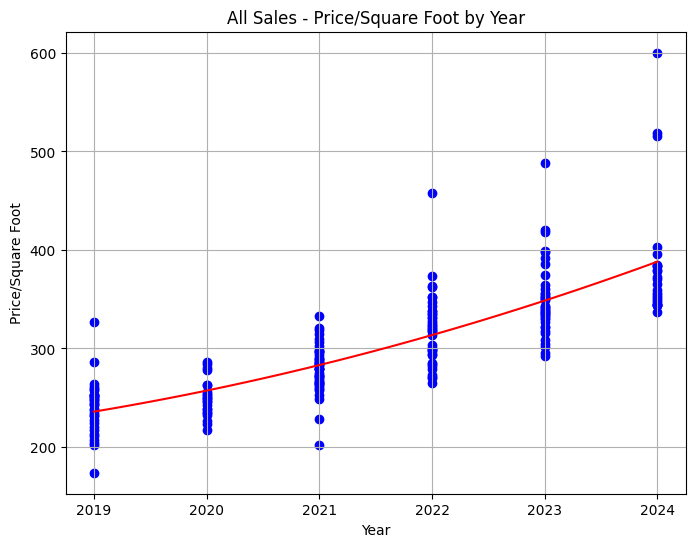

In [6]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_sales['year'], df_sales['sales price/sqft'], marker='o', color='blue', label='Data Points')
plt.title('All Sales - Price/Square Foot by Year')
plt.xlabel('Year')
plt.ylabel('Price/Square Foot')
plt.grid(True)
plt.xticks(range(int(df_sales['year'].min()), int(df_sales['year'].max()) + 1))

# # Perform linear regression
# slope, intercept, r_value, p_value, std_err = linregress(df_sales['year'], df_sales['sales price/sqft'])
# trend_line = slope * df_sales['year'] + intercept

# # Plot the trend line
# plt.plot(df_sales['year'], trend_line, color='red', label='Trend Line')

# # Show the plot
# plt.show()

# Fit a quadratic polynomial trend line
coefficients = np.polyfit(df_sales['year'], df_sales['sales price/sqft'], 2)
trend_line = np.poly1d(coefficients)
x_values = np.linspace(df_sales['year'].min(), df_sales['year'].max(), 100)
y_values = trend_line(x_values)

# Plot the trend line
plt.plot(x_values, y_values, color='red')

# Show the plot without legend
plt.show()

In [7]:
# Identify the rows with the oldest 'year' values for each unique address
df_initial_sale = df_sales.sort_values(by='year').groupby('address').head(1)

# Print the DataFrame with the oldest 'year' values
print("Initial Sale table shape: ", df_initial_sale.shape)
df_initial_sale

Initial Sale table shape:  (178, 4)


,address,year,sales_price,sales price/sqft
0,1000 PEDALERS LN,2019,232500,227.050781
103,1804 RUNWAY BLVD,2019,626500,216.782007
98,1733 RUNWAY BLVD,2019,361000,242.119383
97,1732 RUNWAY BLVD,2019,520500,231.025300
93,1725 RUNWAY BLVD,2019,506000,258.823529
...,...,...,...,...
20,918 PEDALERS LN,2024,389000,337.380746
200,992 HANGAR DR,2024,425000,344.129555
25,922 PEDALERS LN,2024,399000,344.559585
29,926 PEDALERS LN,2024,399000,344.559585


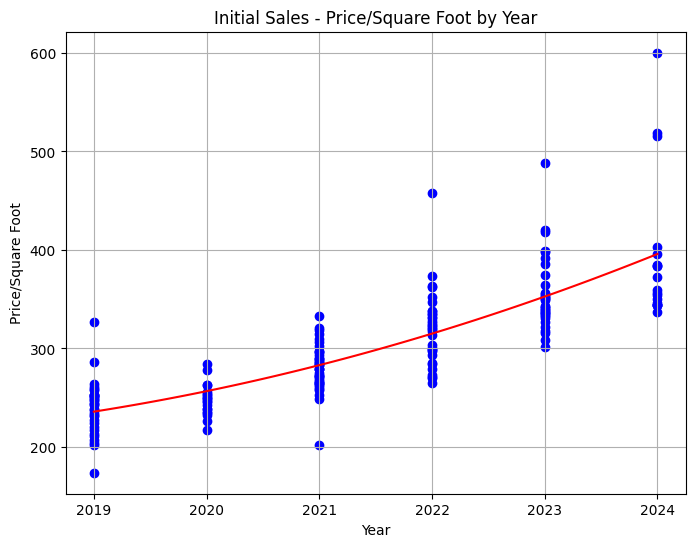

In [8]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_initial_sale['year'], df_initial_sale['sales price/sqft'], marker='o', color='blue', label='Data Points')
plt.title('Initial Sales - Price/Square Foot by Year')
plt.xlabel('Year')
plt.ylabel('Price/Square Foot')
plt.grid(True)
plt.xticks(range(int(df_initial_sale['year'].min()), int(df_initial_sale['year'].max()) + 1))

# Fit a quadratic polynomial trend line
coefficients = np.polyfit(df_initial_sale['year'], df_initial_sale['sales price/sqft'], 2)
trend_line = np.poly1d(coefficients)
x_values = np.linspace(df_initial_sale['year'].min(), df_initial_sale['year'].max(), 100)
y_values = trend_line(x_values)

# Plot the trend line
plt.plot(x_values, y_values, color='red')

# Show the plot without legend
plt.show()

In [9]:
# Create a DataFrame of removed duplicate rows
df_resale = df_sales[~df_sales.index.isin(df_initial_sale.index)]

# Print the DataFrame with removed duplicate rows
print("Re-Sale table shape: ", df_resale.shape)
df_resale

Re-Sale table shape:  (24, 4)


,address,year,sales_price,sales price/sqft
2,1004 PEDALERS LN,2020,215000,280.678851
6,1009 PEDALERS LN,2022,228000,351.851852
9,1021 PEDALERS LN,2023,285000,360.759494
16,915 PEDALERS LN,2023,367500,292.595541
23,921 PEDALERS LN,2022,410000,343.383585
31,932 PEDALERS LN,2024,237000,365.740741
32,932 PEDALERS LN,2021,185000,285.493827
34,933 PEDALERS LN,2020,260000,223.367698
37,937 PEDALERS LN,2022,253000,294.528522
39,940 PEDALERS LN,2023,345000,295.629820


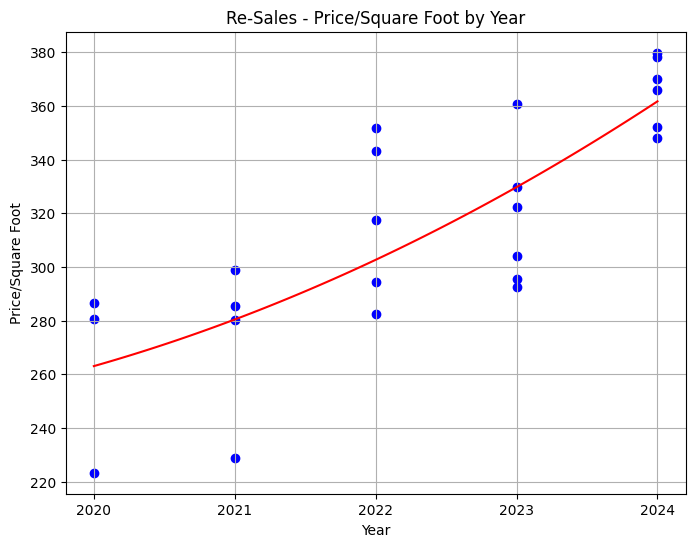

In [10]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_resale['year'], df_resale['sales price/sqft'], marker='o', color='blue', label='Data Points')
plt.title('Re-Sales - Price/Square Foot by Year')
plt.xlabel('Year')
plt.ylabel('Price/Square Foot')
plt.grid(True)
plt.xticks(range(int(df_resale['year'].min()), int(df_resale['year'].max()) + 1))

# Fit a quadratic polynomial trend line
coefficients = np.polyfit(df_resale['year'], df_resale['sales price/sqft'], 2)
trend_line = np.poly1d(coefficients)
x_values = np.linspace(df_resale['year'].min(), df_resale['year'].max(), 100)
y_values = trend_line(x_values)

# Plot the trend line
plt.plot(x_values, y_values, color='red')

# Show the plot without legend
plt.show()

### Remove homes that haven't been given a market value

In [11]:
# Remove NaN values from the specified columns
filtered_df = filtered_df.dropna(subset=['most_recent_market_value'])
print("Filtered Shape: ", filtered_df.shape)
filtered_df

Filtered Shape:  (159, 19)


,address,square_feet,market_values,sales_prices,year_built,bedrooms,bathrooms,garage_sqft,garage_apt_sqft,porch_sqft,unfin_attic_sqft,most_recent_sales_year,most_recent_sales_price,most_recent_market_value,total_sqft,sales_price/square_foot,value_diff,has_garage,has_apt
0,1000 PEDALERS LN,1024.0,"{2024: 358500, 2023: 331500, 2022: 284500, 202...",{2019: 232500},2018.0,3.0,1.5,0.0,0.0,71.0,0.0,2019.0,232500.0,358500.0,1024.0,227.050781,126000.0,0,0
1,1001 PEDALERS LN,1167.0,"{2024: 395500, 2023: 369000, 2022: 317000, 202...",{2019: 246000},2018.0,3.0,1.5,0.0,0.0,69.0,0.0,2019.0,246000.0,395500.0,1167.0,210.796915,149500.0,0,0
2,1004 PEDALERS LN,766.0,"{2024: 315500, 2023: 281500, 2022: 242000, 202...","{2020: 215000, 2019: 197500}",2018.0,2.0,1.5,0.0,0.0,56.0,0.0,2020.0,215000.0,315500.0,766.0,280.678851,100500.0,0,0
3,1005 PEDALERS LN,756.0,"{2024: 311000, 2023: 277500, 2022: 237500, 202...",{2019: 191000},2018.0,1.0,1.0,0.0,0.0,102.0,0.0,2019.0,191000.0,311000.0,756.0,252.645503,120000.0,0,0
4,1008 PEDALERS LN,1164.0,"{2024: 381000, 2023: 353500, 2022: 303000, 202...",{2019: 248500},2018.0,3.0,1.5,0.0,0.0,72.0,0.0,2019.0,248500.0,381000.0,1164.0,213.487973,132500.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,1821 WHEELER ST,1535.0,"{2024: 505000, 2023: 484000, 2022: 419000}",{2021: 429000},2020.0,3.0,3.0,448.0,0.0,198.0,0.0,2021.0,429000.0,505000.0,1535.0,279.478827,76000.0,1,0
166,1825 WHEELER ST,1498.0,"{2024: 495500, 2023: 430000, 2022: 430000}",{2021: 434000},2020.0,3.0,2.5,448.0,0.0,198.0,0.0,2021.0,434000.0,495500.0,1498.0,289.719626,61500.0,1,0
167,1829 WHEELER ST,1496.0,"{2024: 495000, 2023: 474000, 2022: 410000}",{2021: 429000},2020.0,3.0,2.5,448.0,0.0,198.0,0.0,2021.0,429000.0,495000.0,1496.0,286.764706,66000.0,1,0
168,1833 WHEELER ST,1535.0,"{2024: 505000, 2023: 484000, 2022: 419000}",{2021: 429000},2020.0,3.0,3.0,448.0,0.0,198.0,0.0,2021.0,429000.0,505000.0,1535.0,279.478827,76000.0,1,0


### Heatmap

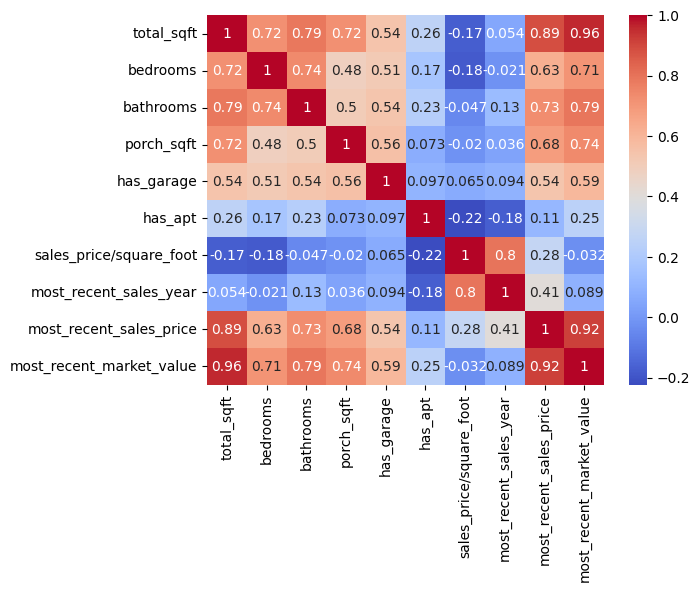

In [12]:
# Create dataframe of worthwhile features to plot
plotworthy_df = pd.DataFrame(data=filtered_df[['total_sqft', 'bedrooms', 'bathrooms', 'porch_sqft', 'has_garage', 'has_apt', 'sales_price/square_foot', 'most_recent_sales_year', 'most_recent_sales_price', 'most_recent_market_value']])

# Compute the correlation matrix
corr_matrix = plotworthy_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Pair Plots

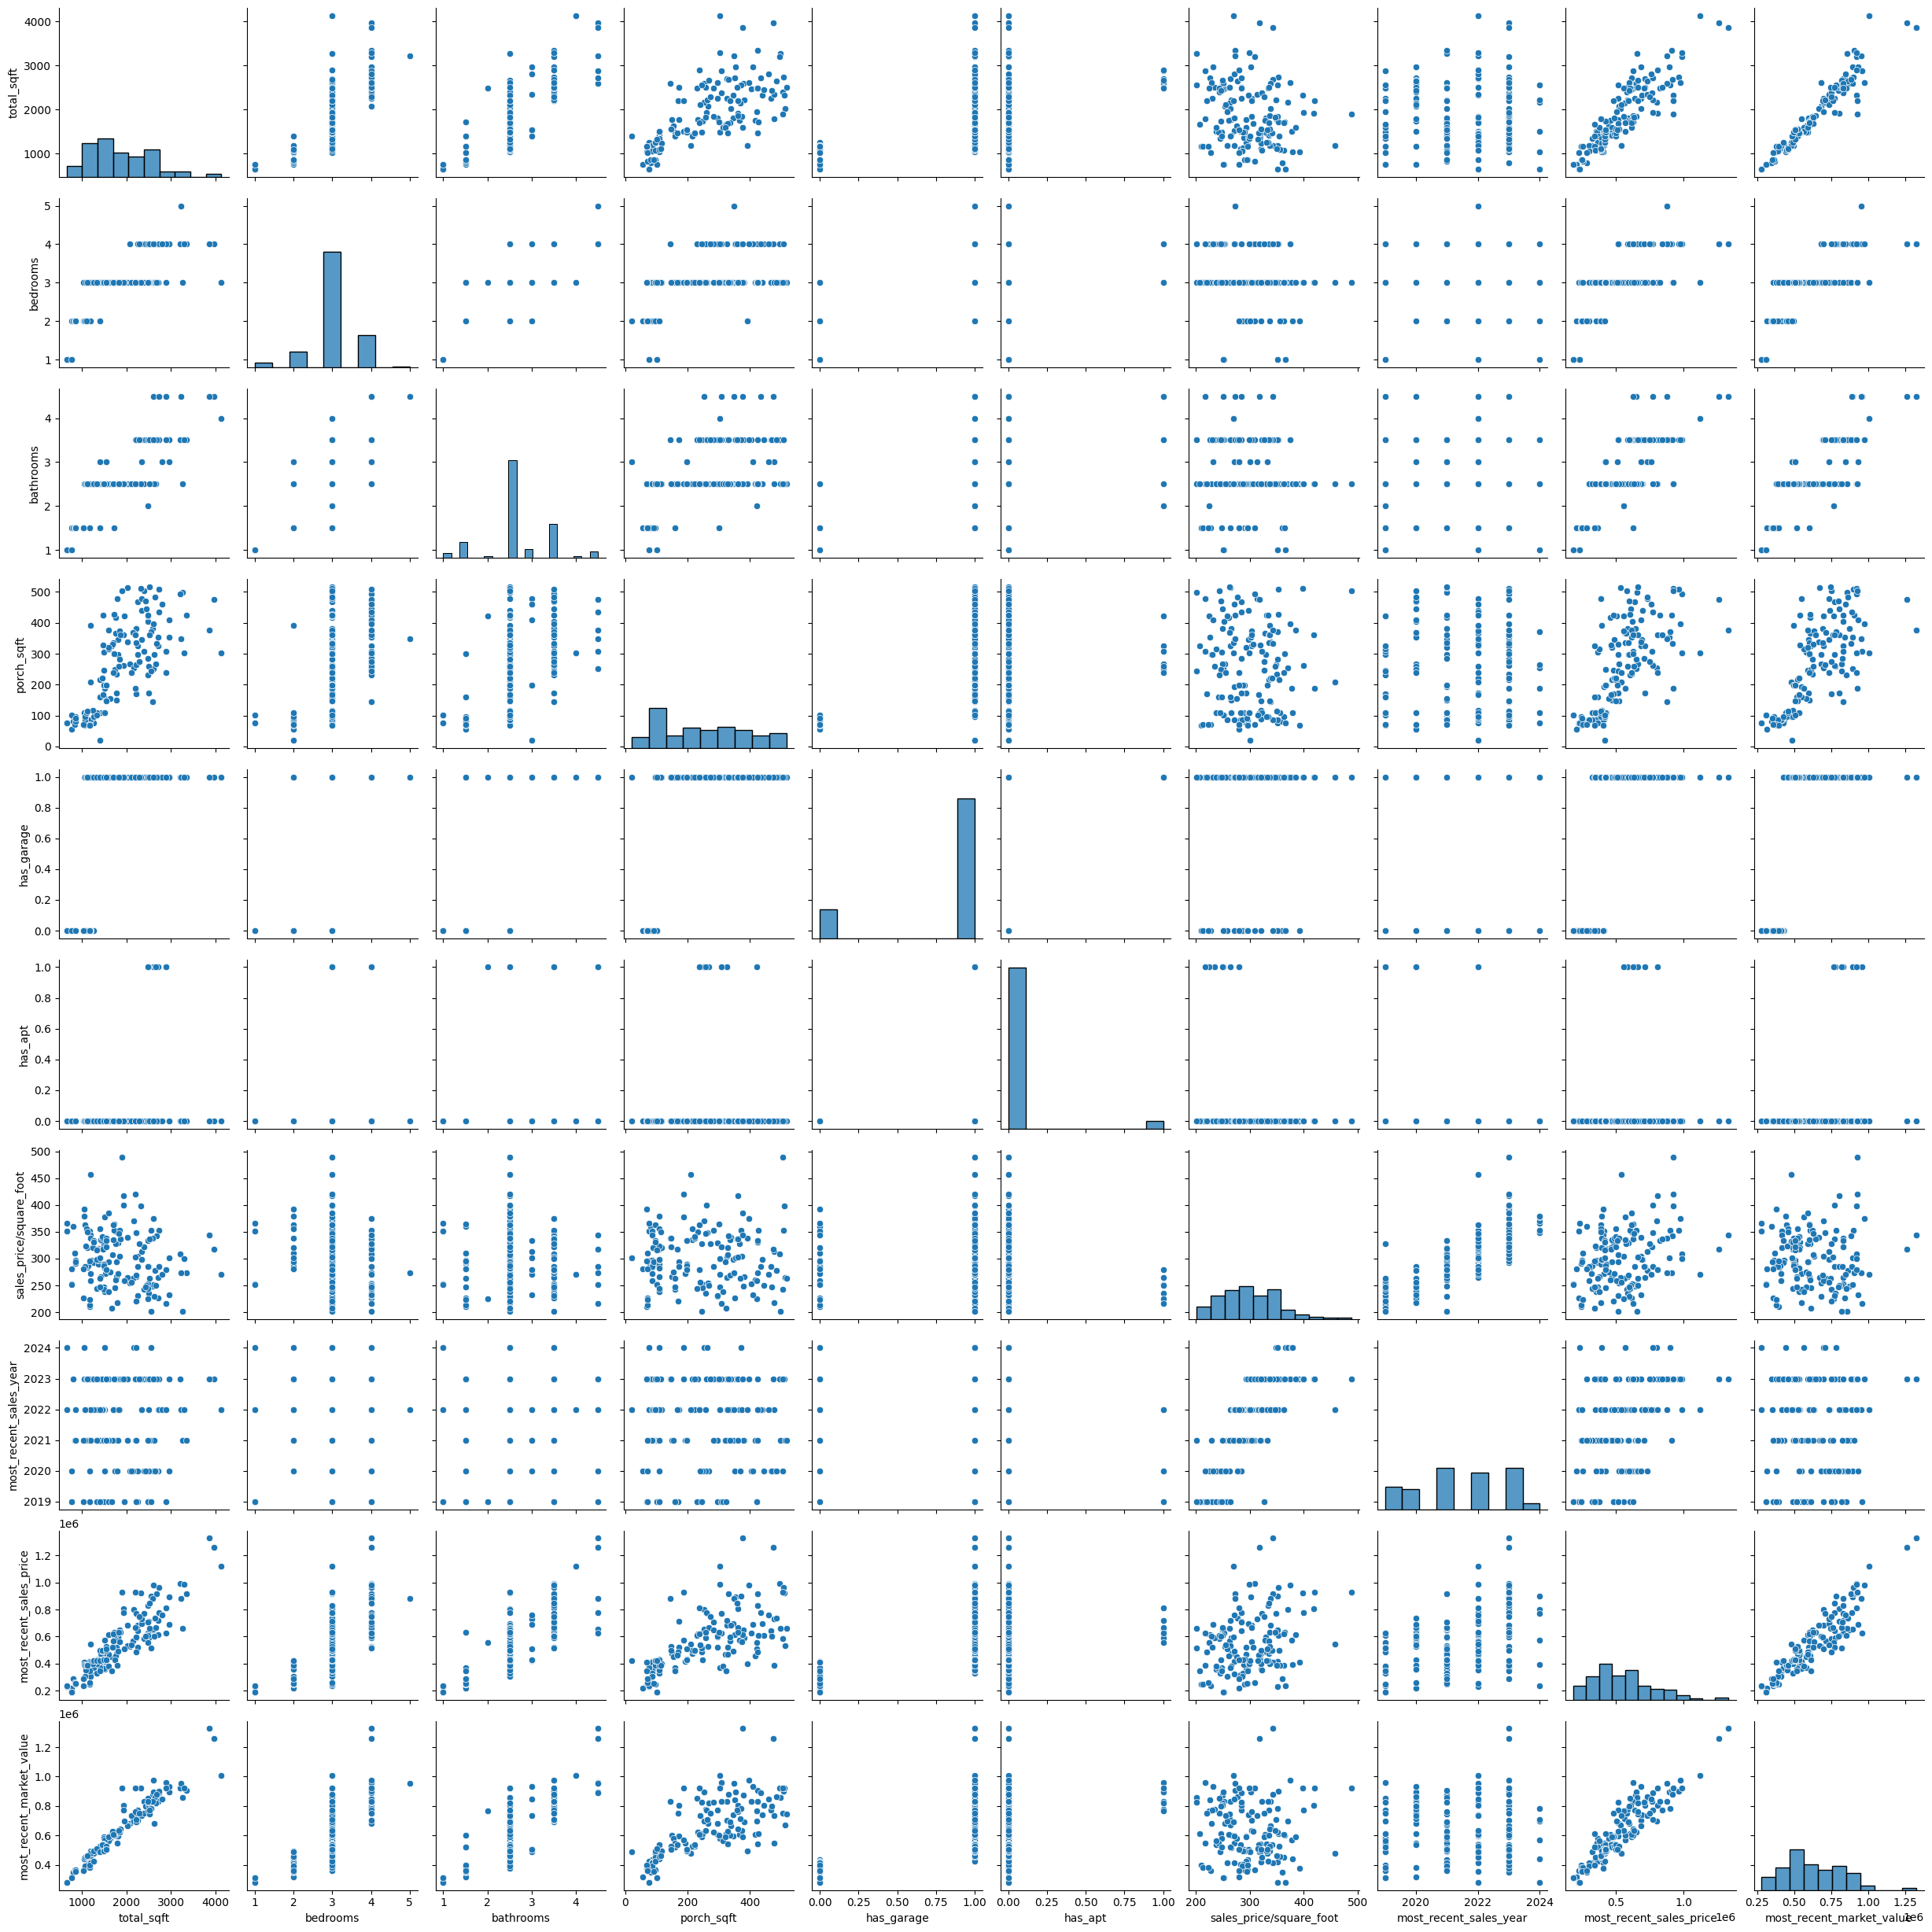

In [13]:
# Create a pair plot
sns.pairplot(plotworthy_df)
plt.show()

### Remove Outliers from the Datafame

In [14]:
# Create new dataframe
data = filtered_df.copy()

# Specify the column to remove outliers from
# column = 'value_diff'
column = 'sales_price/square_foot'

# Calculate Z-scores for the specified column
mean = data[column].mean()
std = data[column].std()
z_scores = (data[column] - mean) / std

# Define a threshold for outliers (e.g., 2 standard deviations)
threshold = 2

outliers = np.abs(z_scores) > threshold

print("Outliers found:", outliers.sum())

# Remove outliers
df_no_outliers = data[~outliers]

# Show outliers
df_outliers = data[outliers]
print("Shape of resulting dataframe with no outliers: ", df_no_outliers.shape)
print("Outliers dataframe: ", df_outliers.shape)
df_outliers


Outliers found: 4
Shape of resulting dataframe with no outliers:  (155, 19)
Outliers dataframe:  (4, 19)


,address,square_feet,market_values,sales_prices,year_built,bedrooms,bathrooms,garage_sqft,garage_apt_sqft,porch_sqft,unfin_attic_sqft,most_recent_sales_year,most_recent_sales_price,most_recent_market_value,total_sqft,sales_price/square_foot,value_diff,has_garage,has_apt
60,1909 PIONEER ST,1926.0,{2024: 804000},{2023: 805000},2022.0,3.0,2.5,528.0,0.0,362.0,0.0,2023.0,805000.0,804000.0,1926.0,417.964694,-1000.0,1,0
135,1801 OSO AVE,1183.0,"{2024: 479000, 2023: 542500}",{2022: 541500},2022.0,3.0,2.5,264.0,0.0,209.0,0.0,2022.0,541500.0,479000.0,1183.0,457.734573,-62500.0,1,0
150,1900 OSO AVE,1893.0,{2024: 924000},{2023: 925000},2022.0,3.0,2.5,572.0,0.0,504.0,0.0,2023.0,925000.0,924000.0,1893.0,488.642367,-1000.0,1,0
153,1904 OSO AVE,2202.0,{2024: 924000},{2023: 925000},2022.0,3.0,2.5,525.0,0.0,187.0,0.0,2023.0,925000.0,924000.0,2202.0,420.072661,-1000.0,1,0


# Test different types of Linear Regression models

In [15]:
# Break into features and labels
X = df_no_outliers[['total_sqft', 'year_built', 'bedrooms', 'bathrooms', 'has_garage', 'has_apt']].values
y = df_no_outliers['most_recent_market_value'].values

# Break out training and testing portions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a function to evaluate different models
def evaluate_model(model, X, y):
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    mse_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

    print(f'Mean Squared Error: {np.mean(mse_scores)}')
    print(f'R2 Score: {np.mean(r2_scores)}')

# Identify the numerical and categorical columns
numerical_columns = [0, 1, 2, 3]  # Indices for the numerical columns in X
binary_columns = [4, 5]  # Indices for the binary columns in X

# Define transformers for preprocessing
numerical_transformer = StandardScaler()  # You can also use MinMaxScaler()
binary_transformer = 'passthrough'

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('binary', binary_transformer, binary_columns)
    ])

# Linear Regression
model1 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', LinearRegression())])
print("Linear Regression:")
evaluate_model(model1, X, y)

# Ridge Regression
model2 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', Ridge(alpha=1.0))])
print("\nRidge Regression:")
evaluate_model(model2, X, y)

# Lasso Regression
alphas = np.logspace(-4, 0, 50)  # Define a range of alpha values to test
lasso_cv_model = LassoCV(alphas=alphas, cv=5).fit(X_train, y_train)
best_alpha = lasso_cv_model.alpha_  # Get the best alpha value
model3 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', Lasso(alpha=best_alpha))])
print("\nLasso Regression:")
print("Best alpha value:", best_alpha)
evaluate_model(model3, X, y)

# ElasticNet Regression
model4 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))])
print("\nElasticNet Regression:")
evaluate_model(model4, X, y)

Linear Regression:
Mean Squared Error: 2049232414.0121655
R2 Score: 0.9462418914737523

Ridge Regression:
Mean Squared Error: 2042881742.260292
R2 Score: 0.9462909404880542

Lasso Regression:
Best alpha value: 0.0001
Mean Squared Error: 2049232410.4899533
R2 Score: 0.9462418915608405

ElasticNet Regression:
Mean Squared Error: 2140980792.9707913
R2 Score: 0.9426507538794484


### It appears the Ridge Regression has the best performance

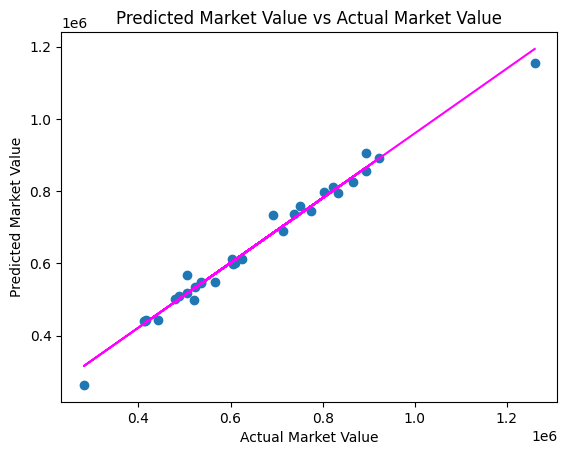

In [16]:
# Use model2 which is associated with the Ridge Regression model in the previous code block
market_model = model2.fit(X_train, y_train)
predictions = market_model.predict(X_test)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Market Value')
plt.ylabel('Predicted Market Value')
plt.title('Predicted Market Value vs Actual Market Value')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Sales Price Linear Regression

MSE: 2775227368.7642484
RMSE: 52680.426808865624
R2: 0.9673723696807027


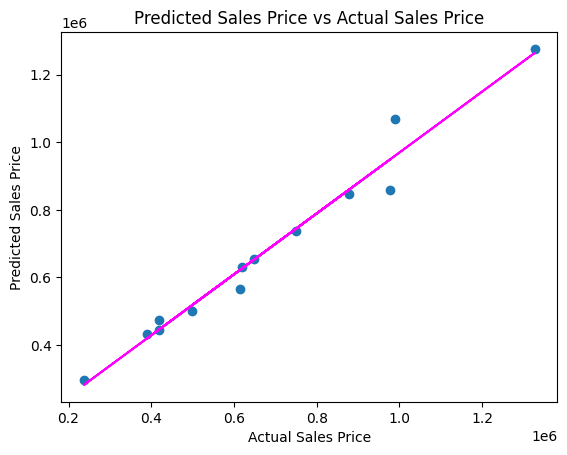

In [17]:
# Clean the data by removing sales data from before 2023 and break into features and labels
recent_df = df_no_outliers[df_no_outliers['most_recent_sales_year'] >= 2023]
X = recent_df[['total_sqft', 'year_built', 'bedrooms', 'bathrooms', 'has_garage', 'has_apt']].values
y = recent_df['most_recent_sales_price'].values

# Split data into training/testing groups and create a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
sales_model = LinearRegression().fit(X_train, y_train)
predictions = sales_model.predict(X_test)

# Determine how well the model predicts
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Sales Price')
plt.ylabel('Predicted Sales Price')
plt.title('Predicted Sales Price vs Actual Sales Price')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Un-comment this section to allow the user to input custom home information to predict

In [18]:
# # Allows user to input square footage to be used in the prediction
# total_sqft = int(input("Enter a total square footage amount (ex. 2050) to predict sales price and market value:"))
# year_built = int(input("Enter a year that the home was built (ex. 2019) to predict sales price and market value:"))
# bedrooms = int(input("Enter the number of bedrooms (ex. 3) to predict sales price and market value:"))
# bathrooms = int(input("Enter the number of bathrooms (ex. 2.5) to predict sales price and market value:"))
# has_garage = int(input("Enter 1 if there is a garage, 0 if not:"))
# has_apt = int(input("Enter 1 if there is a garage apartment, 0 if not:"))

## Predictions

In [19]:
# Predict sales price
# predicted_sales = sales_model.predict([[total_sqft, year_built, bedrooms, bathrooms, has_garage, has_apt]])[0]
predicted_sales = sales_model.predict([[1800, 2021, 3, 3, 1, 0]])[0]
formatted_sales_price = "${:,.0f}".format(predicted_sales)
print("Predicted Sales Price: ", formatted_sales_price)

# Predict market value
# predicted_market_value = market_model.predict([[total_sqft, year_built, bedrooms, bathrooms, has_garage, has_apt]])[0]
predicted_market_value = market_model.predict([[1800, 2021, 3, 3, 1, 0]])[0]
formatted_market_value = "${:,.0f}".format(predicted_market_value)
print("Predicted Market Value: ", formatted_market_value)

Predicted Sales Price:  $617,043
Predicted Market Value:  $628,810
